Polytrope Notes
====================

1  Problem Setup
-------------

In this example, we create an adiabatically stratified polytropic profile and use it to generate a custom reference state file.  We follow Jones et al. (2011; Icarus 216, 120).  The polytrope has a form given by  

$\rho=\rho_0 z^n$,
-----------

$P=P_0 z^{n+1}$,  
----------

and  

$T=T_0 z$,  
-------

where $\rho$, $P$, and $T$ are the density, pressure, and temperature respectively, and where the polytropic variable $z$ is an as-of-yet undetermined function of radius.  We further assume that these quantities are related by the ideal gas law, with  

$P=R\rho T$,
----------

where $R$ is the gas constant.  It is related to the specific heats at constant pressure ($c_p$) and contant volume ($c_v$) through the relation  

$R=c_p-c_v=c_p(1-\frac{1}{\gamma})$,  
----------

with  

$\gamma\equiv \frac{c_p}{c_v}$.
----------

For a monotomic ideal gas, we have that

$\gamma\equiv \frac{5}{3}$.  
-----------


Finally, we require the poltrope satisfies hydrostatic balance.  Namely,

$\rho\frac{GM}{r^2}=-\frac{\partial P}{\partial r}$,  
------------------

where $G$ is the gravitational constant, and $M$ is the mass of the star.



2  Polytropic Solution
--------------------

Substituting our relations for $P$, $\rho$, and $T$ into the equation of hydrostatic balance, we arive at

$\frac{\partial z}{\partial r}= - \frac{GM}{(n+1)RT_0 r^2} = - \frac{2GM}{5(n+1)c_pT_0 r^2}  $ .
----------

This motivates us to seek a form for $z$ of  

$z = a +\frac{b}{r}$,
-----------
and immediately, we see that b must be given by

$b = \frac{2GM}{5(n+1)c_pT_0}$.
--------------

Note that while $T_0$ remains undetermined, we can now compute $\partial T/\partial r$.  In order to determine $a$, we need one more constraint.  In our case, we will specify the number of density scaleheights, $N_\rho$, across the convection zone.   We denote the top of the convection zone by a subscript $t$ and the base of the convection zone by a subscript $b$.  We then have (my browser isn't displaying the fraction lines below)

$N_\rho = \frac{ \rho_b }{ \rho_t } = \frac{z_b^n}{z_t^n}$,  
-----------------

or equivalently, using shorhands $C$ to denote the exponential factor, and $\beta \equiv \frac{r_b}{r_t}$, we have

$C\equiv e^{\frac{N_\rho}{n}} = \frac{a+b/r_b}{a+b/r_t}$.
---------------

Rearranging, we find our expression for $a$

$a = \frac{fb}{r_b}$,  
---------------

where  

$f \equiv \frac{\beta C-1}{1-C}$.  
--------------

This yields our expression for $z$ in terms of $T_0$

$z = b (\frac{1}{r} +\frac{f}{r_b} )= \frac{2GM}{5(n+1)c_pT_0}\left(\frac{1}{r} +\frac{f}{r_b} \right)$.
---------------

Factors of $T_0$ cancel out, when calculating the temperature, leaving us with a complete description of its functional form.   We are free to choose any value of $T_0$ as a result;   we use $T_b$, the temperature at the base of the convection zone.   We have that

$T_0 = T_b = \frac{2GM}{5(n+1)c_p}\left(\frac{1+f}{r_b}\right)$,
---------------------------------

completing our description of z.  Values for $\rho_0$ and $P_0$ can now similarly be computed by enforcing the value of $\rho$ and $P$ as a particular point.  As with $T$, we choose the base of the convection zone in the code that follows.

3  Polytropic Calculation
---------------------

The next few cells contain the code necessary to generate our polytrope.  First, we note a few points:
1.   The number of radial gridpoints nr does not need to equal what you use in Rayleigh.  The code will interpolate onto its chebyshev grid.  I recommend using a grid of higher resolution here than you plan to use in Rayleigh.  
2.  The radial bounds ri and ro that you choose also need not equal those specified in your main_input file, BUT they should extend to or beyond the boundaries of the computational domain.  I.e., ri <= rmin and ro >= rmax.

In [2]:
#######################
import numpy
import matplotlib.pyplot as plt
import reference_tools as rt
from rayleigh_diagnostics import ReferenceState

In [3]:

# Grid Parameters
nr    = 512         # Number of radial points
ri    = 5.0e10      # Inner-most bounds of radial domain
ro    = 6.586e10    # Outer-most bounds of radial domain
rn   = 5.0e10      # Used below as reference point for Nrho (ri <= rn <= ro)

#Poltrope Parameters
ncz   = 1.5         # polytropic index of convection zone

nrho  = 3.0         # number of density scaleheights between ro and rn
mass  = 1.98891e33  # Mass of the star
G     = 6.67e-8     # gravitational constant
rhoi  = 0.18053428  # density at r=rn
cp    = 3.5e8       # specific heat at constant pressure
gamma = 5.0/3.0     # Ratio of specific heats for ideal gas


custom_file='my_polytrope.dat'  # The file to store our reference state in


In [8]:
# Define the Radial Grid

radius = numpy.linspace(ri,ro,nr)           # Full domain radial grid for reference, extended polytrope

gravity = G*mass/radius/radius

def volume_average(f,radius):
    rmin = numpy.min(radius)
    rmax = numpy.max(radius)
    vol = 1.0/3.0*(rmax**3 - rmin**3)
    integrand= radius*radius*f
    fint = numpy.trapz(integrand,x=radius)
    favg = fint/vol
    return favg


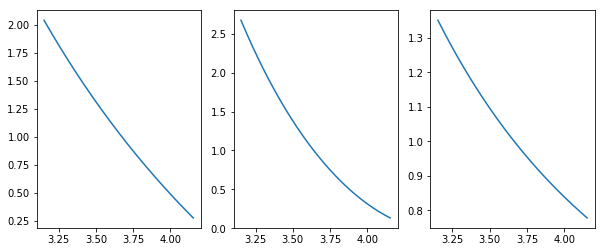

In [12]:
#Compute a full-domain and cz-only polytrope

poly = rt.gen_poly(radius,ncz,nrho,mass,rhoi,G,cp,rn)


#Extended polytrope
temperature = poly.temperature
density     = poly.density
pressure           = poly.pressure
dsdr        = poly.entropy_gradient
entropy           = poly.entropy
dpdr        = poly.pressure_gradient


tavg = volume_average(temperature,radius)
temperature_nd = temperature/tavg

davg = volume_average(density,radius)
density_nd = density/davg

gavg = volume_average(gravity,radius)
gravity_nd = gravity/gavg


radius_nd = radius/(numpy.max(radius)-numpy.min(radius))
ftup= (10,4)
fig, ax = plt.subplots(ncols=3,figsize=ftup)
ax[0].plot(radius_nd, temperature_nd)
ax[1].plot(radius_nd,density_nd)
ax[2].plot(radius_nd,gravity_nd)

plt.show()

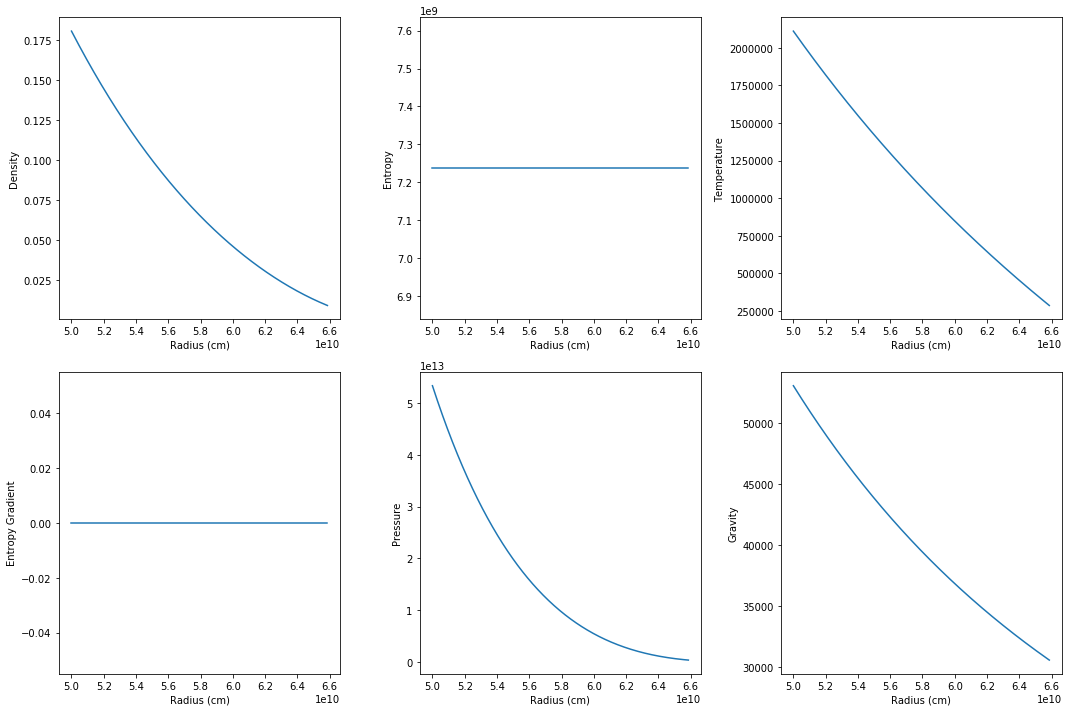

In [6]:
# We now have r_join, rho_join, s_join, and ds_join
# Let's interpolate them back onto the uniform radial grid.
# Names from here have no 'tags'.  They are explicit:  density, entropy, dsdr, and so on


gas_constant = cp*(1.0-1.0/gamma)  # R
#temperature = pressure/density/gas_constant
gravity     = mass*G/radius**2

d_density_dr = numpy.gradient(density,radius, edge_order=2)
dlnrho = d_density_dr/density
d2lnrho = numpy.gradient(dlnrho,radius, edge_order=2)

dtdr = numpy.gradient(temperature,radius, edge_order =2)
dlnt = dtdr/temperature

fig, ax = plt.subplots(nrows =2,ncols = 3, figsize=(15,10) )
ax[0][0].plot(radius,density)
ax[0][0].set_xlabel('Radius (cm)')
ax[0][0].set_ylabel('Density')

ax[0][1].plot(radius,entropy)
ax[0][1].set_xlabel('Radius (cm)')
ax[0][1].set_ylabel('Entropy')

ax[0][2].plot(radius,temperature)
ax[0][2].set_xlabel('Radius (cm)')
ax[0][2].set_ylabel('Temperature')


ax[1][0].plot(radius,dsdr)
ax[1][0].set_xlabel('Radius (cm)')
ax[1][0].set_ylabel('Entropy Gradient')

ax[1][1].plot(radius,pressure)
ax[1][1].set_xlabel('Radius (cm)')
ax[1][1].set_ylabel('Pressure')

ax[1][2].plot(radius,gravity)
ax[1][2].set_xlabel('Radius (cm)')
ax[1][2].set_ylabel('Gravity')

plt.tight_layout()

plt.show()

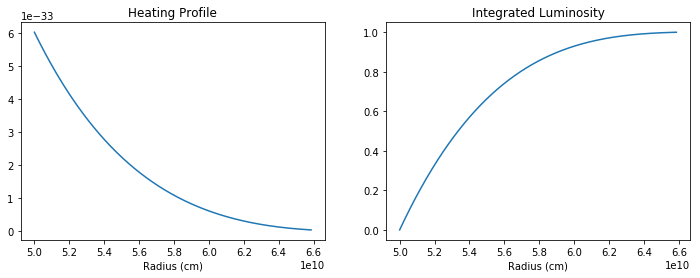

In [7]:
#####################################################################
# Next, we generate a heating function
# Units are energy / volume / time such that {rho_hat T_hat dS/dt} = hprofile(r)
# As in Featherstone and Hindman (2016), we make the heating proportional to pressure

hprofile = numpy.zeros(nr,dtype='float64')
hprofile[:] = pressure[:]

#################################################################
# We normalize the heating function so that it integrates to 1.
# This allows us to control the total luminosity by setting Rayleigh
# constant 10 in the main_input file.
integrand= numpy.pi*4*radius*radius*hprofile
hint = numpy.trapz(integrand,x=radius)
hprofile = hprofile/hint



###########################################################
# Check:
# Plot the integrated luminosity as a function of radius
# (should integrate to 1 at r = r_top)
lq = numpy.zeros(nr)
lq[0]=0
integrand= numpy.pi*4*radius*radius*hprofile
for i in range(1,nr):
    lq[i] = numpy.trapz(integrand[0:i+1],x=radius[0:i+1])
    
fig, ax = plt.subplots(ncols=2,figsize=(12,4))


ax[0].plot(radius,hprofile)
ax[0].set_title('Heating Profile')
ax[0].set_xlabel('Radius (cm)')

ax[1].plot(radius,lq)
ax[1].set_title('Integrated Luminosity')
ax[1].set_xlabel('Radius (cm)')

plt.show()

In [ ]:
## We are now ready to create our reference state file...
#from rayleigh_diagnostics import equation_coefficients

In [ ]:
my_ref = rt.equation_coefficients(radius)

In [ ]:

unity = numpy.zeros(nr,dtype='float64')
unity[:] =1
buoy = density*gravity/cp

buoy_nd = density_nd*gravity_nd

hprofile_nd = hprofile*...

my_ref.set_function(density_nd,1)
my_ref.set_function(buoy_nd,2)        # multiplies entropy in momentum equation
my_ref.set_function(unity,3)       # nu(r) -- can be overwritten via nu_type in Rayleigh
my_ref.set_function(temperature_nd,4) 
my_ref.set_function(unity,5)       # kappa(r) -- works like nu
my_ref.set_function(hprofile,6)   # heating -- will deal with this shortly

my_ref.set_function(dlnrho,8)
my_ref.set_function(d2lnrho,9)
my_ref.set_function(dlnt,10)
my_ref.set_function(unity,7)    # eta -- works like nu and kappa
my_ref.set_function(dsdr,14)
my_ref.set_function(entropy,15)
my_ref.set_function(pressure, 16)

# Most of the constants below are used for nondimensionalization
# The constants can all be set/overridden in the input file
# It's importan to note that they default to ZERO, but we want
# most of them to be UNITY.  
# These aren't very useful in our dimensional anelastic formulation
my_ref.set_constant(1.0,1)  # Should be 2 Omega (complication here)
my_ref.set_constant(1.0,2)  # multiplies buoyancy
my_ref.set_constant(1.0,3)  # multiplies pressure gradient
my_ref.set_constant(0.0,4)  # multiplies lorentz force
my_ref.set_constant(1.0,5)  # multiplies viscosity
my_ref.set_constant(1.0,6)  # multiplies entropy diffusion (kappa)
my_ref.set_constant(0.0,7)  # multiplies eta in induction equation
my_ref.set_constant(1.0,8)  # multiplies viscous heating
my_ref.set_constant(1.0,9)  # multiplies ohmic heating
my_ref.set_constant(1.0,10) # multiplies the heating (if normalized to 1, this is the luminosity)
my_ref.write(custom_file)
print(my_ref.fset)
print(my_ref.cset)

In [ ]:
#Once you're run for one time step, set have_run = True
have_run = True
if (have_run):
    cref = ReferenceState()
    lsun = 3.846e33
    # Use numpy to calculate logarithmic derivatives (check on what Rayleigh is doing...)
    #d_density_dr = numpy.gradient(density,radius, edge_order=2)
    #dlnrho = d_density_dr/density
    #d2lnrho = numpy.gradient(dlnrho,radius, edge_order=2)

    #dtdr = numpy.gradient(temperature,radius)
    #dlnt = dtdr/temperature
    
    fig, ax = plt.subplots(ncols=3,nrows=4, figsize=(16,4*4))
    # Density variables
    ax[0][0].plot(cref.radius,cref.density,'yo')
    ax[0][0].plot(radius,density)
    ax[0][0].set_xlabel('Radius (cm)')
    ax[0][0].set_title('Density')
    
    ax[0][1].plot(cref.radius, cref.dlnrho,'yo')
    ax[0][1].plot(radius, dlnrho)
    ax[0][1].set_xlabel('Radius (cm)')
    ax[0][1].set_title('Log density gradient')
    
    ax[0][2].plot(cref.radius,cref.d2lnrho,'yo')
    ax[0][2].plot(radius,d2lnrho)
    ax[0][2].set_xlabel('Radius (cm)')
    ax[0][2].set_title('d_dr{Log density gradient}')
        
    ax[1][0].plot(cref.radius,cref.temperature,'yo')
    ax[1][0].plot(radius,temperature)
    ax[1][0].set_xlabel('Radius (cm)')
    ax[1][0].set_title('Temperature')
    
    ax[1][1].plot(cref.radius, cref.dlnt,'yo')
    ax[1][1].plot(radius, dlnt)
    ax[1][1].set_xlabel('Radius (cm)')
    ax[1][1].set_title('Log temperature gradient')

    # Entropy
    ax[2][0].plot(cref.radius,cref.entropy,'yo')
    ax[2][0].plot(radius,entropy)
    ax[2][0].set_xlabel('Radius (cm)')
    ax[2][0].set_title('Entropy')
    
    ax[2][1].plot(cref.radius, cref.dsdr,'yo')
    ax[2][1].plot(radius, dsdr)
    ax[2][1].set_xlabel('Radius (cm)')
    ax[2][1].set_title('Log entropy gradient')   

    
    #Pressure, Gravity, Heating
    ax[3][0].plot(cref.radius,cref.pressure,'yo')
    ax[3][0].plot(radius,pressure)
    ax[3][0].set_xlabel('Radius (cm)')
    ax[3][0].set_title('Pressure')
    
    ax[3][1].plot(cref.radius, cref.gravity,'yo')
    ax[3][1].plot(radius, gravity*density/cp)
    ax[3][1].set_xlabel('Radius (cm)')
    ax[3][1].set_title('Gravity')   

    ax[3][2].plot(cref.radius, cref.heating,'yo')
    #ax[3][2].plot(radius, hprofile/density/temperature*lsun)
    ax[3][2].set_xlabel('Radius (cm)')
    ax[3][2].set_title('Heating')      
    
    plt.tight_layout()
    plt.show()


In [ ]:
help(cref)


In [ ]:
from rayleigh_diagnostics import TransportCoeffs
trans = TransportCoeffs()
print(trans.nu)
print(trans.dlnu)
print(trans.kappa)
print(trans.dlnkappa)

In [ ]:
help(trans)

In [ ]:
help(numpy.gradient)